## MAGnet: Multi-Region Attention-Assisted Grounding of Natural Language Queries at Phrase Level

Code and visualizations to test, debug, and evaluate the model.

In [1]:
import mute
import os
import sys
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import utils as utils
import visualize
from visualize import display_images, display_images_c
import model as modellib
from model import *
from model import log
from train import *

# Other configurations are using from train.py file
# Check point of trained model
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
MODEL_DIR = '/media/dataHD3/MAGnet/logs/'
MODEL_PATH = '/media/dataHD3/MAGnet/logs/flickr30k20191003T0144/magnet_flickr30k_0365.h5'

# Setup configurtion for testing
config = CustomConfig()
class InferenceConfig(config.__class__):
    IMAGES_PER_GPU = 1
config = InferenceConfig()
config.display()

Using TensorFlow backend.



Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [16]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
CLASSIFIER_MAX_OVERLAP         0.5
CLASSIFIER_MIN_OVERLAP         0.5
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        64
DETECTION_MIN_CONFIDENCE       0.95
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIC_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                12
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
JSON                           flickr30k.json
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.0001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, '

In [2]:
# Helper function
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Load Test Data

In [3]:
dataset = CustomDataset()
dataset.load_data(config, "test")

100%|██████████| 31780/31780 [00:00<00:00, 32669.30it/s]


## Load Model

In [4]:
embed_mat = dataset.get_embmat()
model = modellib.MAGnet(mode="inference", model_dir=MODEL_DIR, embed_mat=embed_mat, config=config)

print("Loading weights ", MODEL_PATH)
model.load_weights(MODEL_PATH, by_name=True)

1917494it [00:32, 58528.12it/s]                             


Loading weights  /media/dataHD3/MAGnet/logs/flickr30k20191003T0144/magnet_flickr30k_0365.h5


## Run Detection

Image ID: flickr30k.2350 (2350) 
Caption:  purple pants
Overlaps = [[0.65627229]]


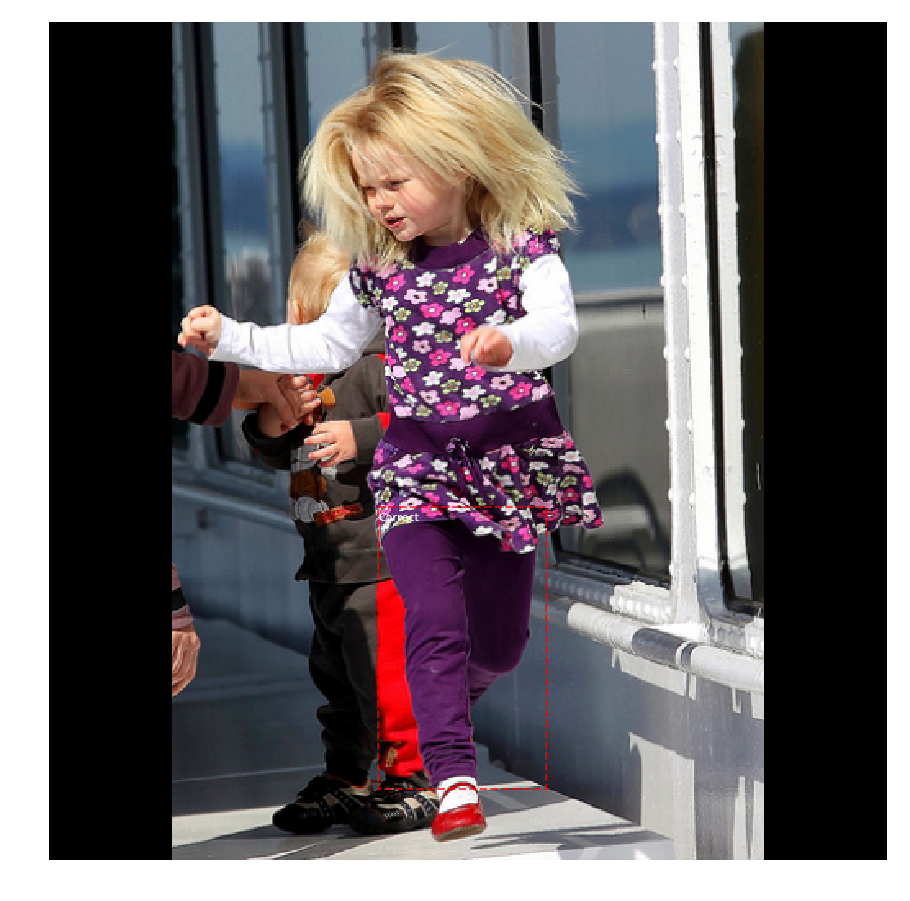

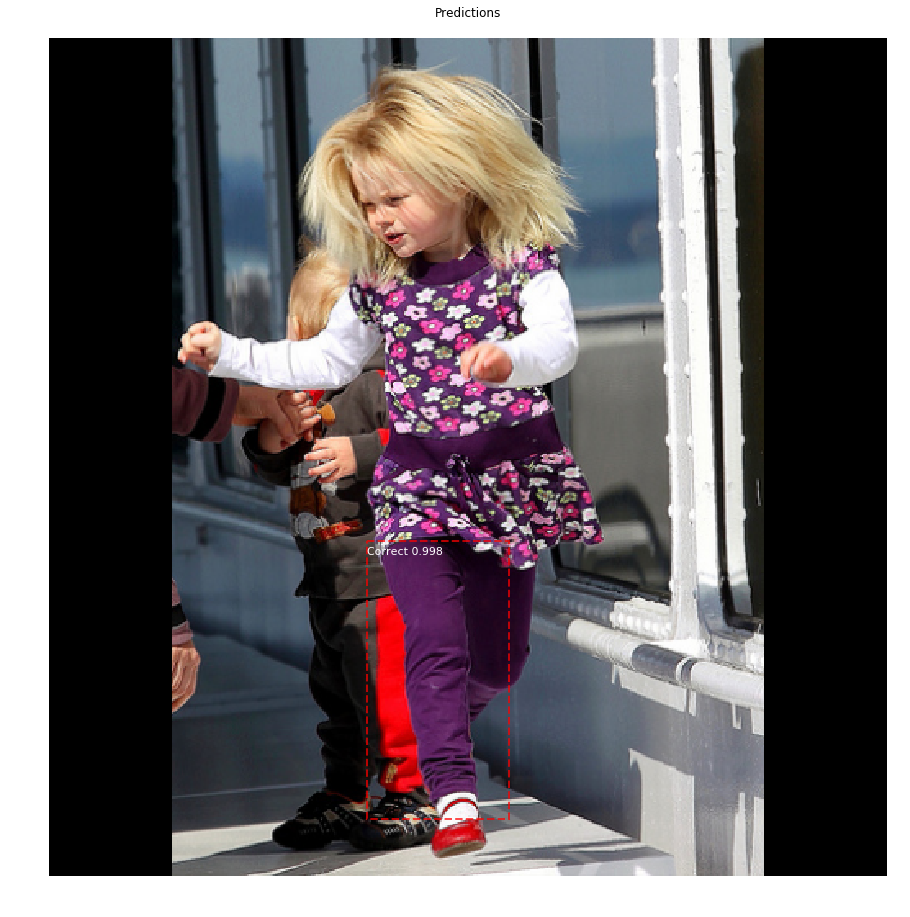

In [29]:
# Random choose image ID
image_id = random.choice(dataset.image_ids1)

# Custom string (Empty will choose from dataset itself)
s = ""

conf = np.zeros([1,1])

# Trasnfrom custom string to embedded vector
if s != "":
    start='<start>'
    end='<eos>'
    stnc = [start]
    txt = s.split(" ")
    stnc.extend(txt)
    stnc.extend([end])
    max_length = 18
    Li = np.zeros((1, max_length), dtype='uint32')
    tli = []

    for k, w in enumerate(stnc):
        if k < max_length:
            if w in dataset.vocab2idx:
                Li[0, k] = dataset.vocab2idx[w]
            else:
                Li[0, k] = dataset.vocab2idx["UNK"]
                
    print(stnc)
    print(Li)
    
# Get data based on image ID
image, image_meta, gt_class_id, gt_bbox, en_caption, bbox, captions, en_captions = modellib.load_image_gt(dataset, 
                                                                                    config, image_id, 
                                                                                    augmentation=None,
                                                                                    use_mini_mask=False)

# Prepare data
tmpcap = captions[gt_class_id[0] - 1]
gt_class_id[gt_class_id > 0] = 1
info = dataset.image_info[image_id]
prev_caps = np.zeros((config.BATCH_SIZE, config.SEQ_LEN), dtype=int)
prev_caps[0, :len(en_caption)] = en_caption
print("Image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id,dataset.image_reference(image_id)))

if s != "":
    prev_caps = Li

# Choose one of the caption from dataset
target_caps = np.zeros((1, config.SEQ_LEN), dtype=int)
target_caps[0, :-1] = prev_caps[0, 1:]
sample_weight = np.zeros((1, config.SEQ_LEN), dtype=int)
sample_weight[target_caps > 0] = 1

# Set confifence score
conf[0,0] = 0.5

# Run object detection
results = model.detect(prev_caps, sample_weight, conf, [image], verbose=0)
r = results[0]

# Show only the top score based on dection results
if len(r['scores']) != 0:
    mxr = np.amax(r['scores'] * r['class_ids'])
    conf[0,0] = mxr - 0.05
    results = model.detect(prev_caps, sample_weight, conf, [image], verbose=0)
    r = results[0]

# Draw precision-recall curve
_, _, _, overlaps, pred_match, _ = utils.compute_ap(gt_bbox, gt_class_id, r['rois'], r['class_ids'], 
                                                    r['scores'], iou_threshold=0.9)

print("Caption: ", tmpcap)
print('Overlaps = {}'.format(overlaps))

# Display image and instances
visualize.display_instances(image, gt_bbox, gt_class_id, dataset.class_names)

# Display results
ax = get_ax(1)
visualize.display_instances(image, r['rois'], r['class_ids'], dataset.class_names, 
                            r['scores'], ax=ax, title="Predictions")

## Step by Step Prediction
Adapted from: https://github.com/matterport/Mask_RCNN

In [30]:
# Generate RPN trainig targets
# target_rpn_match is 1 for positive anchors, -1 for negative anchors
# and 0 for neutral anchors.
target_rpn_match, target_rpn_bbox = modellib.build_rpn_targets(
    image.shape, model.anchors, gt_class_id, gt_bbox, model.config)
log("target_rpn_match", target_rpn_match)
log("target_rpn_bbox", target_rpn_bbox)

positive_anchor_ix = np.where(target_rpn_match[:] == 1)[0]
negative_anchor_ix = np.where(target_rpn_match[:] == -1)[0]
neutral_anchor_ix = np.where(target_rpn_match[:] == 0)[0]
positive_anchors = model.anchors[positive_anchor_ix]
negative_anchors = model.anchors[negative_anchor_ix]
neutral_anchors = model.anchors[neutral_anchor_ix]
log("positive_anchors", positive_anchors)
log("negative_anchors", negative_anchors)
log("neutral anchors", neutral_anchors)

# Apply refinement deltas to positive anchors
refined_anchors = utils.apply_box_deltas(
    positive_anchors,
    target_rpn_bbox[:positive_anchors.shape[0]] * model.config.RPN_BBOX_STD_DEV)
log("refined_anchors", refined_anchors, )


target_rpn_match         shape: (15360,)              min:   -1.00000  max:    1.00000  int32
target_rpn_bbox          shape: (32, 4)               min:   -0.99437  max:    1.38107  float64
positive_anchors         shape: (4, 4)                min:  194.74517  max:  490.50967  float64
negative_anchors         shape: (28, 4)               min: -314.03867  max:  858.03867  float64
neutral anchors          shape: (15328, 4)            min: -362.03867  max:  858.03867  float64
refined_anchors          shape: (4, 4)                min:  201.00000  max:  468.00000  float32


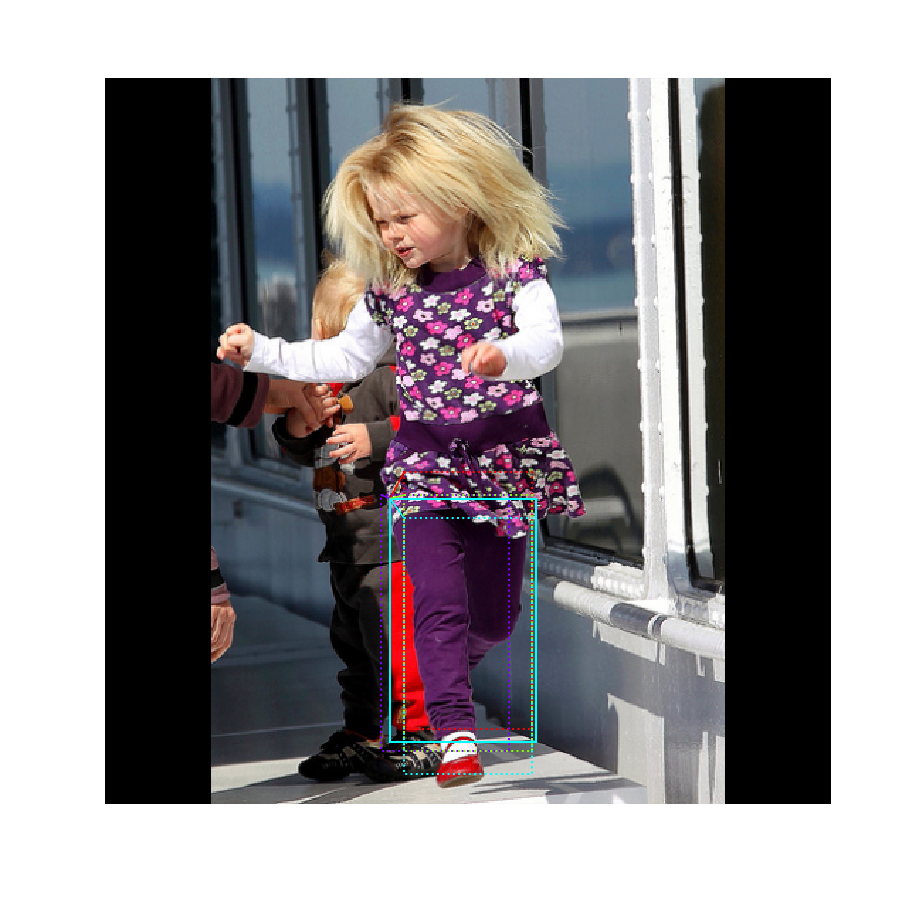

In [31]:
# Display positive anchors before refinement (dotted) and
# after refinement (solid).
visualize.draw_boxes(image, boxes=positive_anchors, refined_boxes=refined_anchors, ax=get_ax())

In [32]:
# Run RPN sub-graph
pillar = model.keras_model.get_layer("ROI").output  # node to start searching from

# TF 1.4 and 1.9 introduce new versions of NMS. Search for all names to support TF 1.3~1.10
nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression:0")
if nms_node is None:
    nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV2:0")
if nms_node is None: #TF 1.9-1.10
    nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV3:0")

rpn = model.run_graph(prev_caps, sample_weight, conf, [image], [
    ("rpn_class", model.keras_model.output[5]),
    ("pre_nms_anchors", model.ancestor(pillar, "ROI/pre_nms_anchors:0")),
    ("refined_anchors", model.ancestor(pillar, "ROI/refined_anchors:0")),
    ("refined_anchors_clipped", model.ancestor(pillar, "ROI/refined_anchors_clipped:0")),
    ("post_nms_anchor_ix", nms_node),
    ("proposals", model.keras_model.get_layer("ROI").output),
])

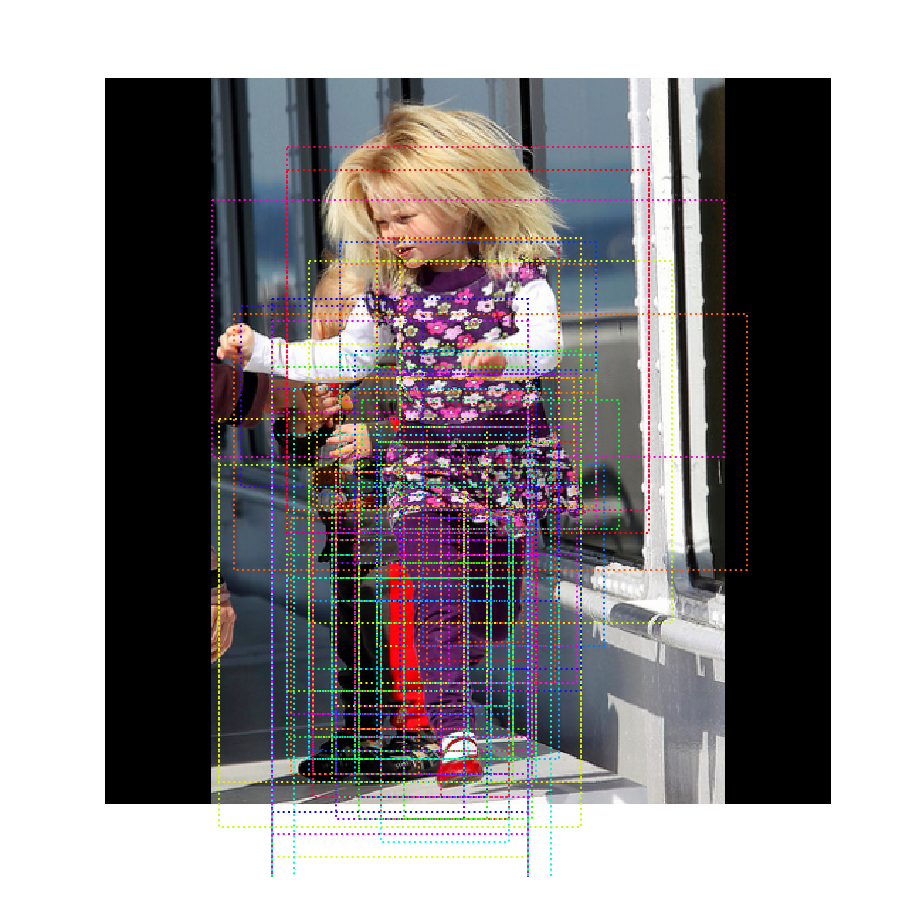

In [33]:
# Show top anchors by score (before refinement)
limit = 100
sorted_anchor_ids = np.argsort(rpn['rpn_class'][:,:,1].flatten())[::-1]
visualize.draw_boxes(image, boxes=model.anchors[sorted_anchor_ids[:limit]], ax=get_ax())

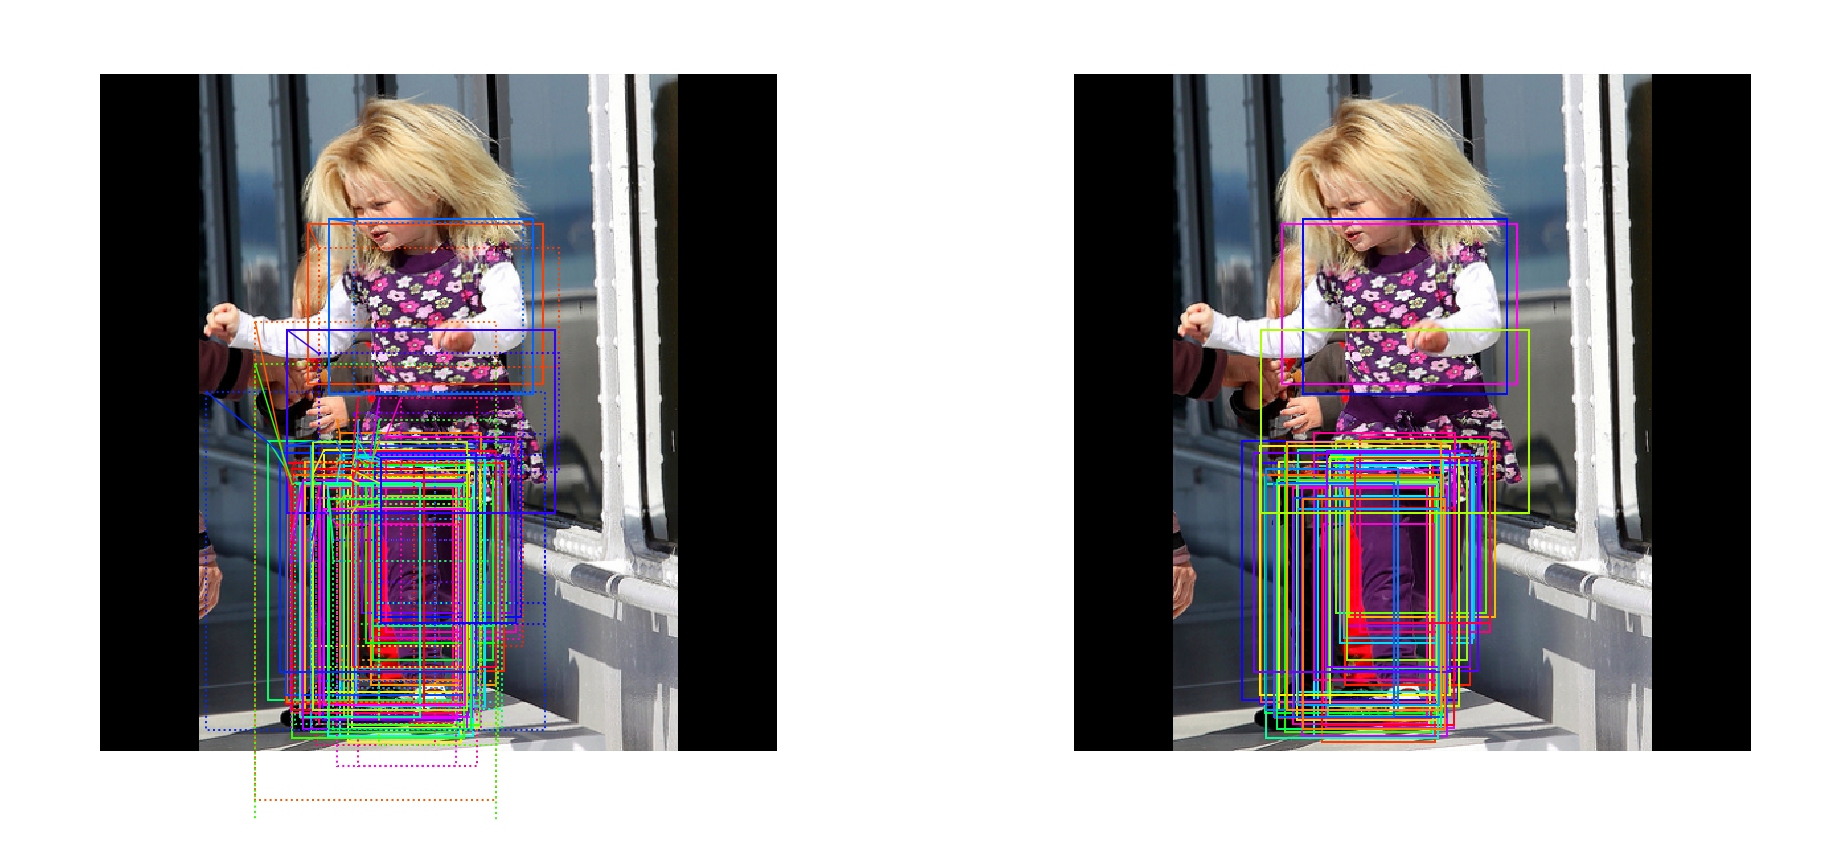

In [34]:
# Show top anchors with refinement. Then with clipping to image boundaries
limit = 50
ax = get_ax(1, 2)
pre_nms_anchors = utils.denorm_boxes(rpn["pre_nms_anchors"][0], image.shape[:2])
refined_anchors = utils.denorm_boxes(rpn["refined_anchors"][0], image.shape[:2])
refined_anchors_clipped = utils.denorm_boxes(rpn["refined_anchors_clipped"][0], image.shape[:2])
visualize.draw_boxes(image, boxes=pre_nms_anchors[:limit],
                     refined_boxes=refined_anchors[:limit], ax=ax[0])
visualize.draw_boxes(image, refined_boxes=refined_anchors_clipped[:limit], ax=ax[1])

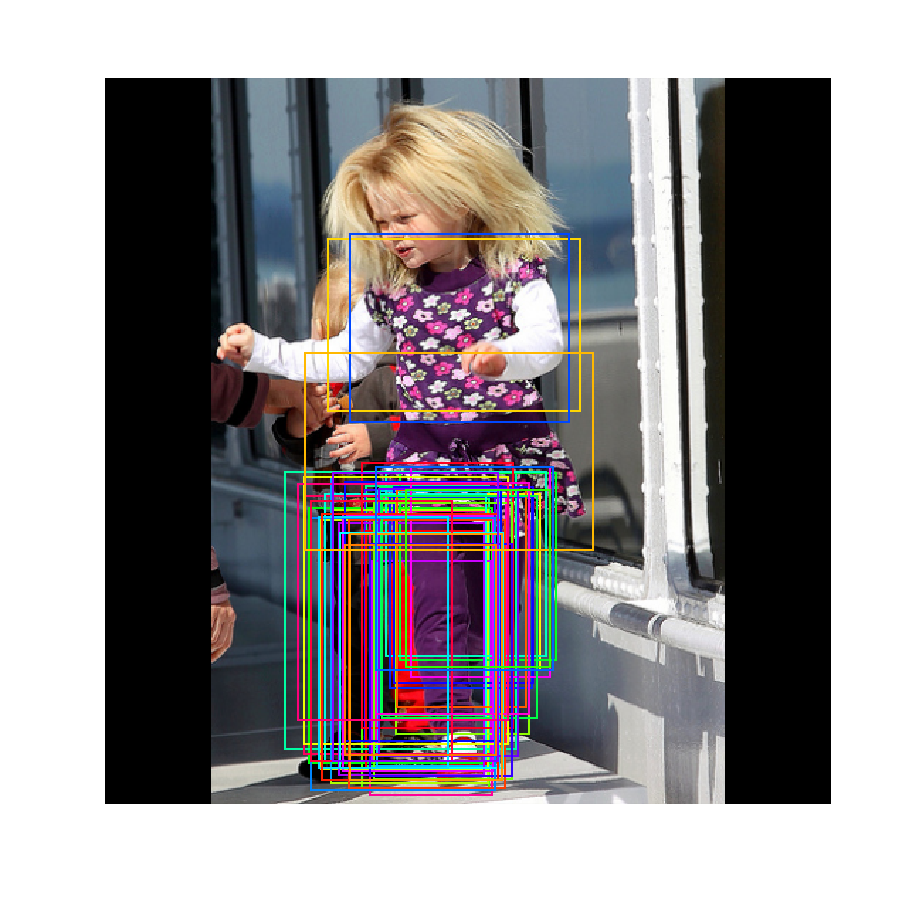

In [35]:
# Show refined anchors after non-max suppression
limit = 50
ixs = rpn["post_nms_anchor_ix"][:limit]
visualize.draw_boxes(image, refined_boxes=refined_anchors_clipped[ixs], ax=get_ax())

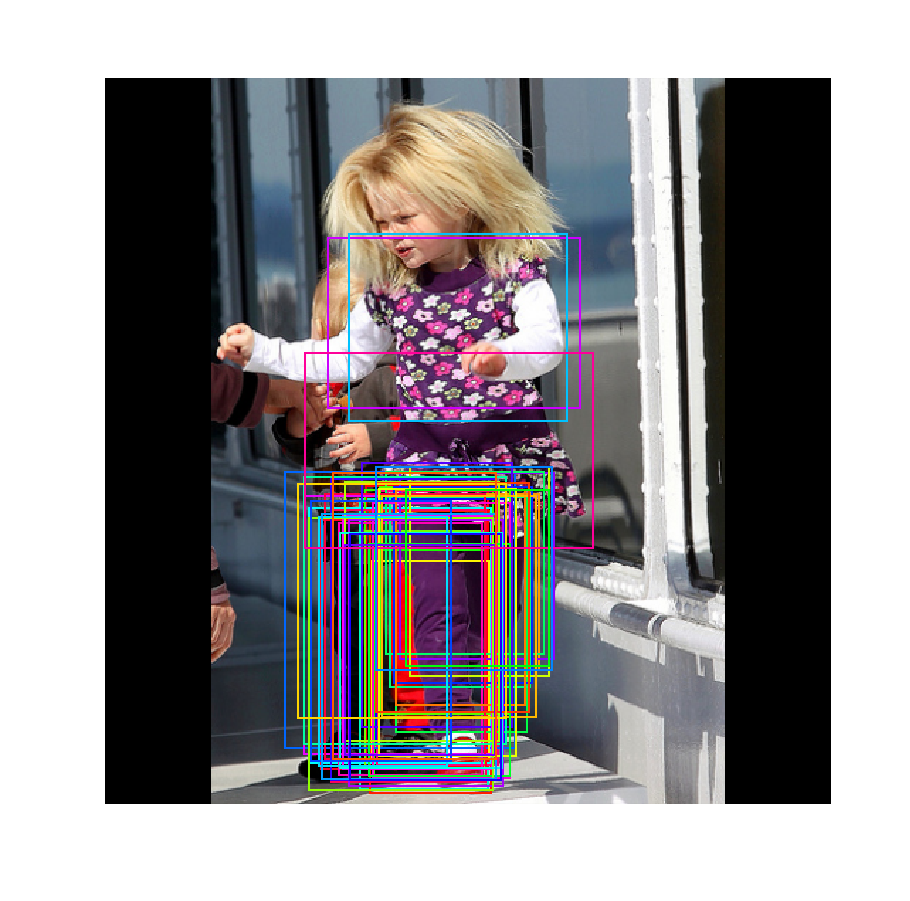

In [36]:
# Show final proposals
# These are the same as the previous step (refined anchors 
# after NMS) but with coordinates normalized to [0, 1] range.
limit = 50
# Convert back to image coordinates for display
h, w = config.IMAGE_SHAPE[:2]
proposals = rpn['proposals'][0, :limit] * np.array([h, w, h, w])
visualize.draw_boxes(image, refined_boxes=proposals, ax=get_ax())

## Proposal Classification

Adapted from: https://github.com/matterport/Mask_RCNN

In [37]:
# Get input and output to classifier and mask heads.
mrcnn = model.run_graph(prev_caps, sample_weight, conf, [image], [
    ("out_words", model.keras_model.get_layer("lang_out").output),
    ("proposals", model.keras_model.get_layer("ROI").output),
    ("probs", model.keras_model.get_layer("mrcnn_class").output),
    ("deltas", model.keras_model.get_layer("mrcnn_bbox").output),
    # ("masks", model.keras_model.get_layer("mrcnn_mask").output),
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
])

1 detections: ['Correct']


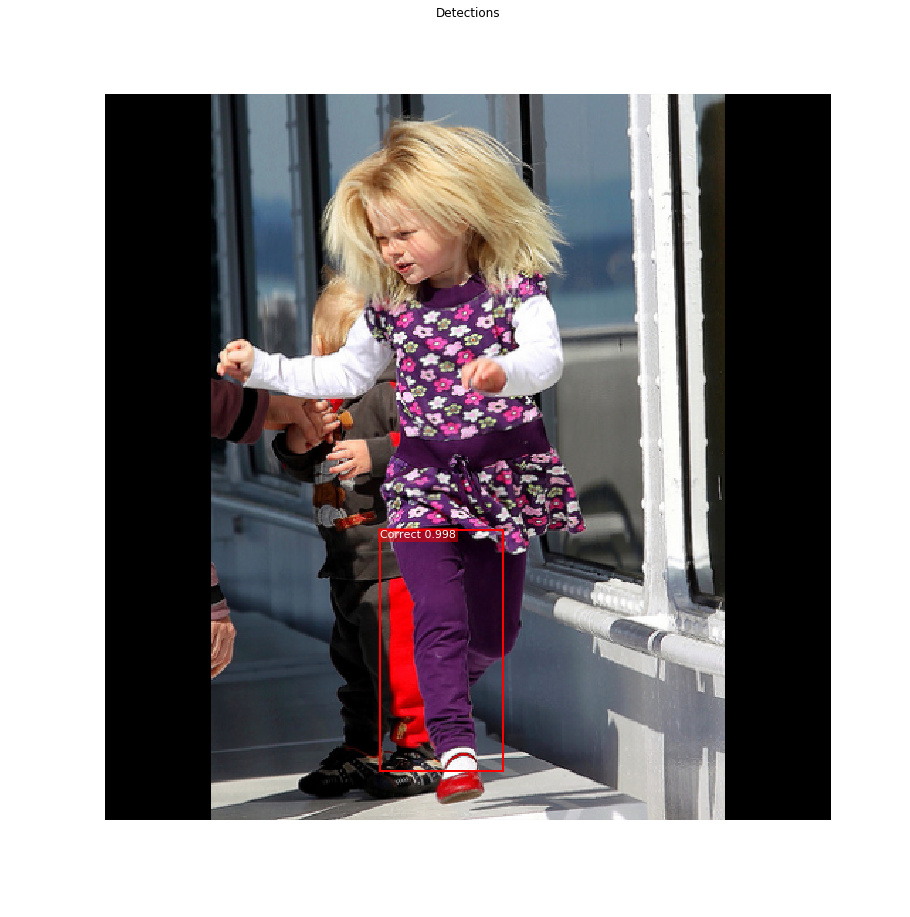

In [38]:
# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]
detections = mrcnn['detections'][0, :det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset.class_names)[det_class_ids]))

captions = ["{} {:.3f}".format(dataset.class_names[int(c)], s) if c > 0 else ""
            for c, s in zip(detections[:, 4], detections[:, 5])]
visualize.draw_boxes(
    image, 
    refined_boxes=utils.denorm_boxes(detections[:, :4], image.shape[:2]),
    visibilities=[2] * len(detections),
    captions=captions, title="Detections",
    ax=get_ax())

In [39]:
# Proposals are in normalized coordinates. Scale them
# to image coordinates.
h, w = config.IMAGE_SHAPE[:2]
proposals = np.around(mrcnn["proposals"][0] * np.array([h, w, h, w])).astype(np.int32)

# Class ID, score, and mask per proposal
roi_class_ids = np.argmax(mrcnn["probs"][0], axis=1)
roi_scores = mrcnn["probs"][0, np.arange(roi_class_ids.shape[0]), roi_class_ids]
roi_class_names = np.array(dataset.class_names)[roi_class_ids]
roi_positive_ixs = np.where(roi_class_ids > 0)[0]

# How many ROIs vs empty rows?
print("{} Valid proposals out of {}".format(np.sum(np.any(proposals, axis=1)), proposals.shape[0]))
print("{} Positive ROIs".format(len(roi_positive_ixs)))

# Class counts
print(list(zip(*np.unique(roi_class_names, return_counts=True))))

200 Valid proposals out of 200
95 Positive ROIs
[('BG', 105), ('Correct', 95)]


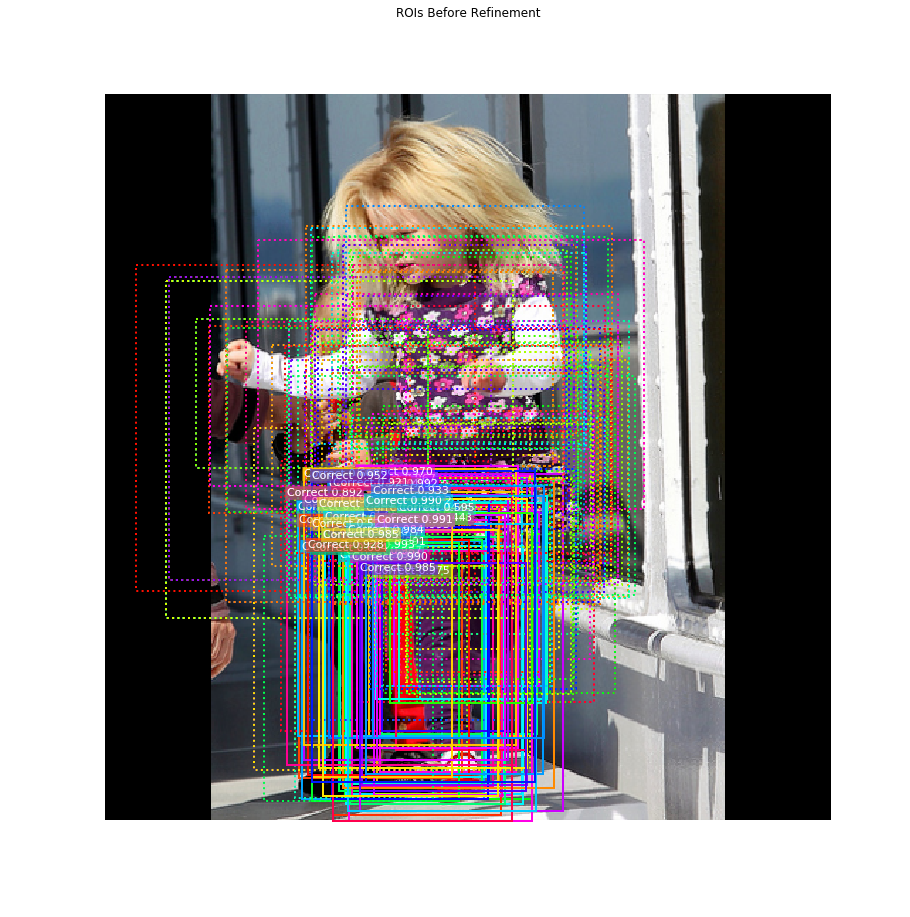

In [40]:
# Display a random sample of proposals.
# Proposals classified as background are dotted, and
# the rest show their class and confidence score.
limit = 200
ixs = np.random.randint(0, proposals.shape[0], limit)
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[ixs], roi_scores[ixs])]
visualize.draw_boxes(image, boxes=proposals[ixs],
                     visibilities=np.where(roi_class_ids[ixs] > 0, 2, 1),
                     captions=captions, title="ROIs Before Refinement",
                     ax=get_ax())

roi_bbox_specific        shape: (200, 4)              min:   -1.36123  max:    3.01067  float32
refined_proposals        shape: (200, 4)              min:   22.00000  max:  498.00000  int32


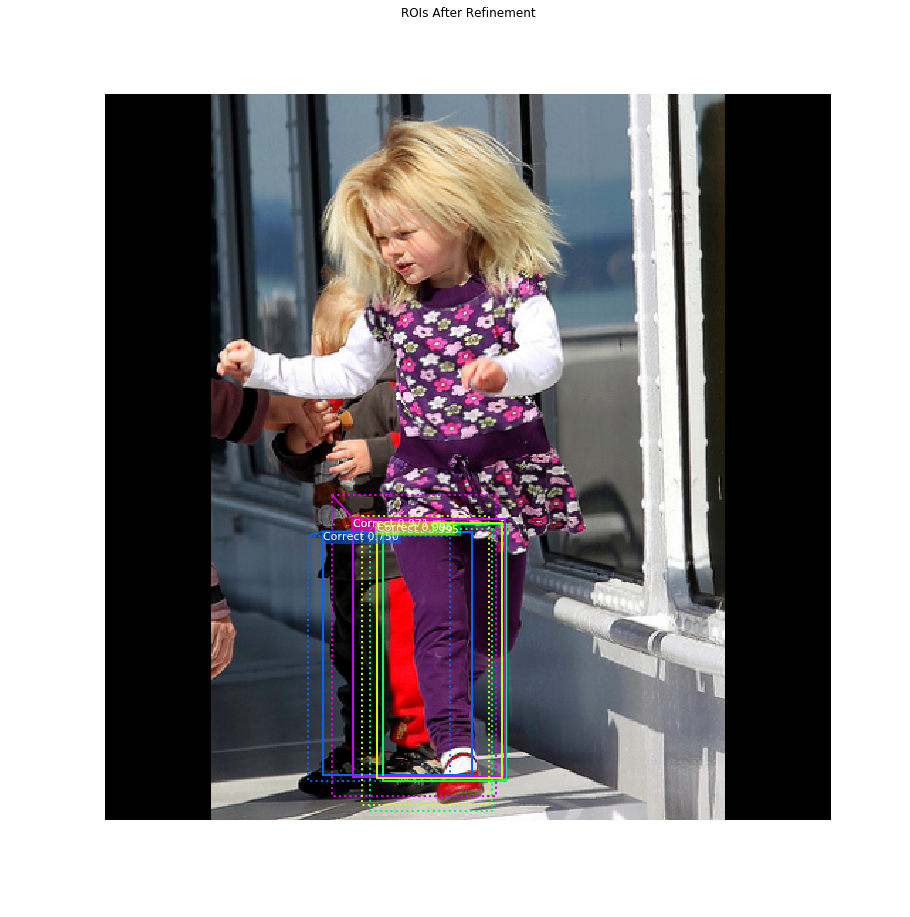

In [41]:
# Class-specific bounding box shifts.
roi_bbox_specific = mrcnn["deltas"][0, np.arange(proposals.shape[0]), roi_class_ids]
log("roi_bbox_specific", roi_bbox_specific)

# Apply bounding box transformations
# Shape: [N, (y1, x1, y2, x2)]
refined_proposals = utils.apply_box_deltas(
    proposals, roi_bbox_specific * config.BBOX_STD_DEV).astype(np.int32)
log("refined_proposals", refined_proposals)

# Show positive proposals
# ids = np.arange(roi_boxes.shape[0])  # Display all
limit = 5
ids = np.random.randint(0, len(roi_positive_ixs), limit)  # Display random sample
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[roi_positive_ixs][ids], roi_scores[roi_positive_ixs][ids])]
visualize.draw_boxes(image, boxes=proposals[roi_positive_ixs][ids],
                     refined_boxes=refined_proposals[roi_positive_ixs][ids],
                     visibilities=np.where(roi_class_ids[roi_positive_ixs][ids] > 0, 1, 0),
                     captions=captions, title="ROIs After Refinement",
                     ax=get_ax())

Keep 95 detections:
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  15  16  17  19
  20  21  22  23  24  26  27  28  29  30  31  32  33  34  36  37  38  39
  40  41  42  43  44  45  53  54  55  56  59  60  63  64  66  67  68  71
  75  78  82  83  87  90  91  92  95  97  99 104 107 108 110 111 120 126
 128 129 130 131 133 140 141 142 148 150 157 160 163 164 166 167 173 179
 181 182 184 189 191]
Remove boxes below 0.9479230761528015 confidence. Keep 59:
[  0   1   2   3   4   5   7   8   9  10  11  13  16  17  22  23  24  27
  28  29  30  31  32  33  36  37  40  42  43  45  53  54  56  60  63  64
  67  68  92  97  99 104 110 128 129 130 131 140 142 148 157 160 163 164
 166 167 181 184 189]


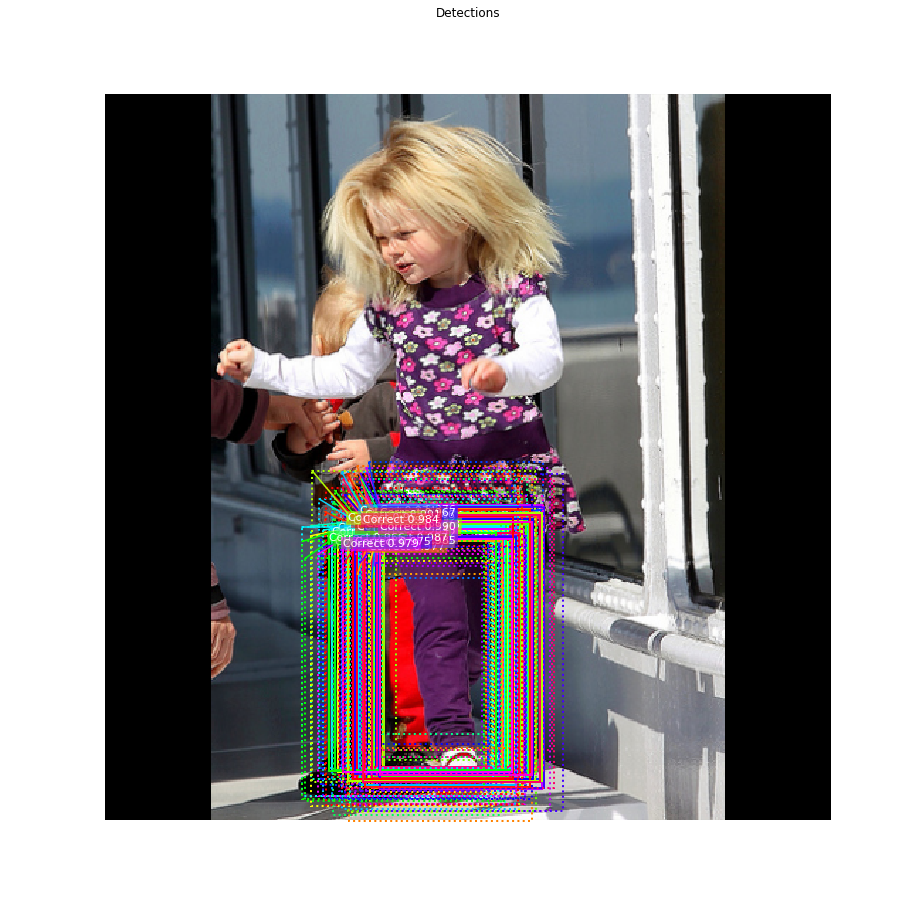

In [42]:
# Remove boxes classified as background
keep = np.where(roi_class_ids > 0)[0]
print("Keep {} detections:\n{}".format(keep.shape[0], keep))

# Remove low confidence detections
keep = np.intersect1d(keep, np.where(roi_scores >= conf[0,0])[0])
print("Remove boxes below {} confidence. Keep {}:\n{}".format(
    conf[0,0], keep.shape[0], keep))

# Show detections before per-class NMS
ixs = np.arange(len(keep))  # Display all
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[keep][ixs], roi_scores[keep][ixs])]
visualize.draw_boxes(
    image, boxes=proposals[keep][ixs],
    refined_boxes=refined_proposals[keep][ixs],
    visibilities=np.where(roi_class_ids[keep][ixs] > 0, 1, 0),
    captions=captions, title="Detections",
    ax=get_ax())

In [43]:
# Apply per-class non-max suppression
pre_nms_boxes = refined_proposals[keep]
pre_nms_scores = roi_scores[keep]
pre_nms_class_ids = roi_class_ids[keep]

nms_keep = []
for class_id in np.unique(pre_nms_class_ids):
    # Pick detections of this class
    ixs = np.where(pre_nms_class_ids == class_id)[0]
    # Apply NMS
    class_keep = utils.non_max_suppression(pre_nms_boxes[ixs], 
                                            pre_nms_scores[ixs],
                                            config.DETECTION_NMS_THRESHOLD)
    # Map indicies
    class_keep = keep[ixs[class_keep]]
    nms_keep = np.union1d(nms_keep, class_keep)
    print("{:22}: {} -> {}".format(dataset.class_names[class_id][:20], 
                                   keep[ixs], class_keep))

keep = np.intersect1d(keep, nms_keep).astype(np.int32)
print("\nKept after per-class NMS: {}\n{}".format(keep.shape[0], keep))

Correct               : [  0   1   2   3   4   5   7   8   9  10  11  13  16  17  22  23  24  27
  28  29  30  31  32  33  36  37  40  42  43  45  53  54  56  60  63  64
  67  68  92  97  99 104 110 128 129 130 131 140 142 148 157 160 163 164
 166 167 181 184 189] -> [8]

Kept after per-class NMS: 1
[8]


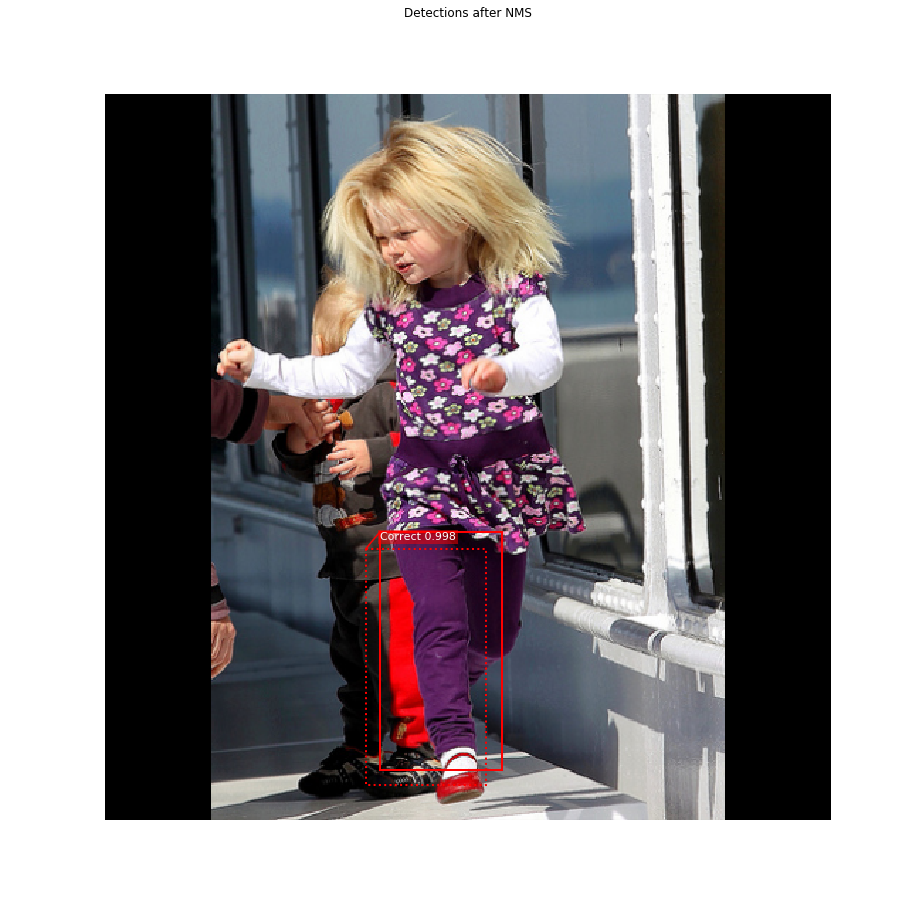

In [44]:
# Show final detections
ixs = np.arange(len(keep))  # Display all
# ixs = np.random.randint(0, len(keep), 10)  # Display random sample
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[keep][ixs], roi_scores[keep][ixs])]
visualize.draw_boxes(
    image, boxes=proposals[keep][ixs],
    refined_boxes=refined_proposals[keep][ixs],
    visibilities=np.where(roi_class_ids[keep][ixs] > 0, 1, 0),
    captions=captions, title="Detections after NMS",
    ax=get_ax())

## Visualize Activations

Adapted from: https://github.com/matterport/Mask_RCNN

In [45]:
# Get activations of a few sample layers
activations = model.run_graph(prev_caps, sample_weight, conf, [image], [
    ("input_image", tf.identity(model.keras_model.get_layer("input_image").output)),
    ("attention_scores", tf.identity(model.keras_model.get_layer("lang_att_scores").output)),
    ("res4f_out", model.keras_model.get_layer("res3d_out").output),  # for resnet100
#     ("res4f_out", model.keras_model.get_layer("block4_pool").output), 
    ("rpn_bbox", model.keras_model.output[6]),
    ("roi", model.keras_model.get_layer("ROI").output),])

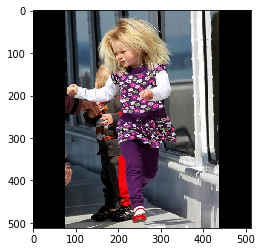

In [46]:
# Input image (normalized)
_ = plt.imshow(modellib.unmold_image(activations["input_image"][0],config))

In [47]:
# Backbone feature map
from scipy.ndimage.interpolation import zoom
from scipy.ndimage.filters import gaussian_filter
sig = 5
th = 0.3
att = activations["attention_scores"][0]

input_image = unmold_image(activations["input_image"][0], config)
masks = np.zeros([18, input_image.shape[0], input_image.shape[1], 3])
for i in range(18):
    s = 32
    att1 = np.reshape(att[i], (s, s))
    att1 = zoom(att1, float(input_image.shape[0]) / att1.shape[-1], order=1)
    att1 = (att1 - (np.min(att1))) / (np.max(att1) - np.min(att1))
    att1 = gaussian_filter(att1, sigma=sig)

    att1[att1 > th] = 1
    att1[att1 <= th] = 0.3
    mask = att1

    for c in range(3):
        masks[i,:, :, c] = input_image[:, :, c] * mask

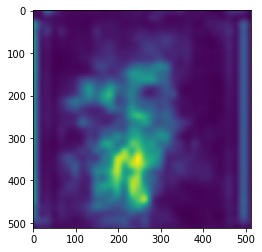

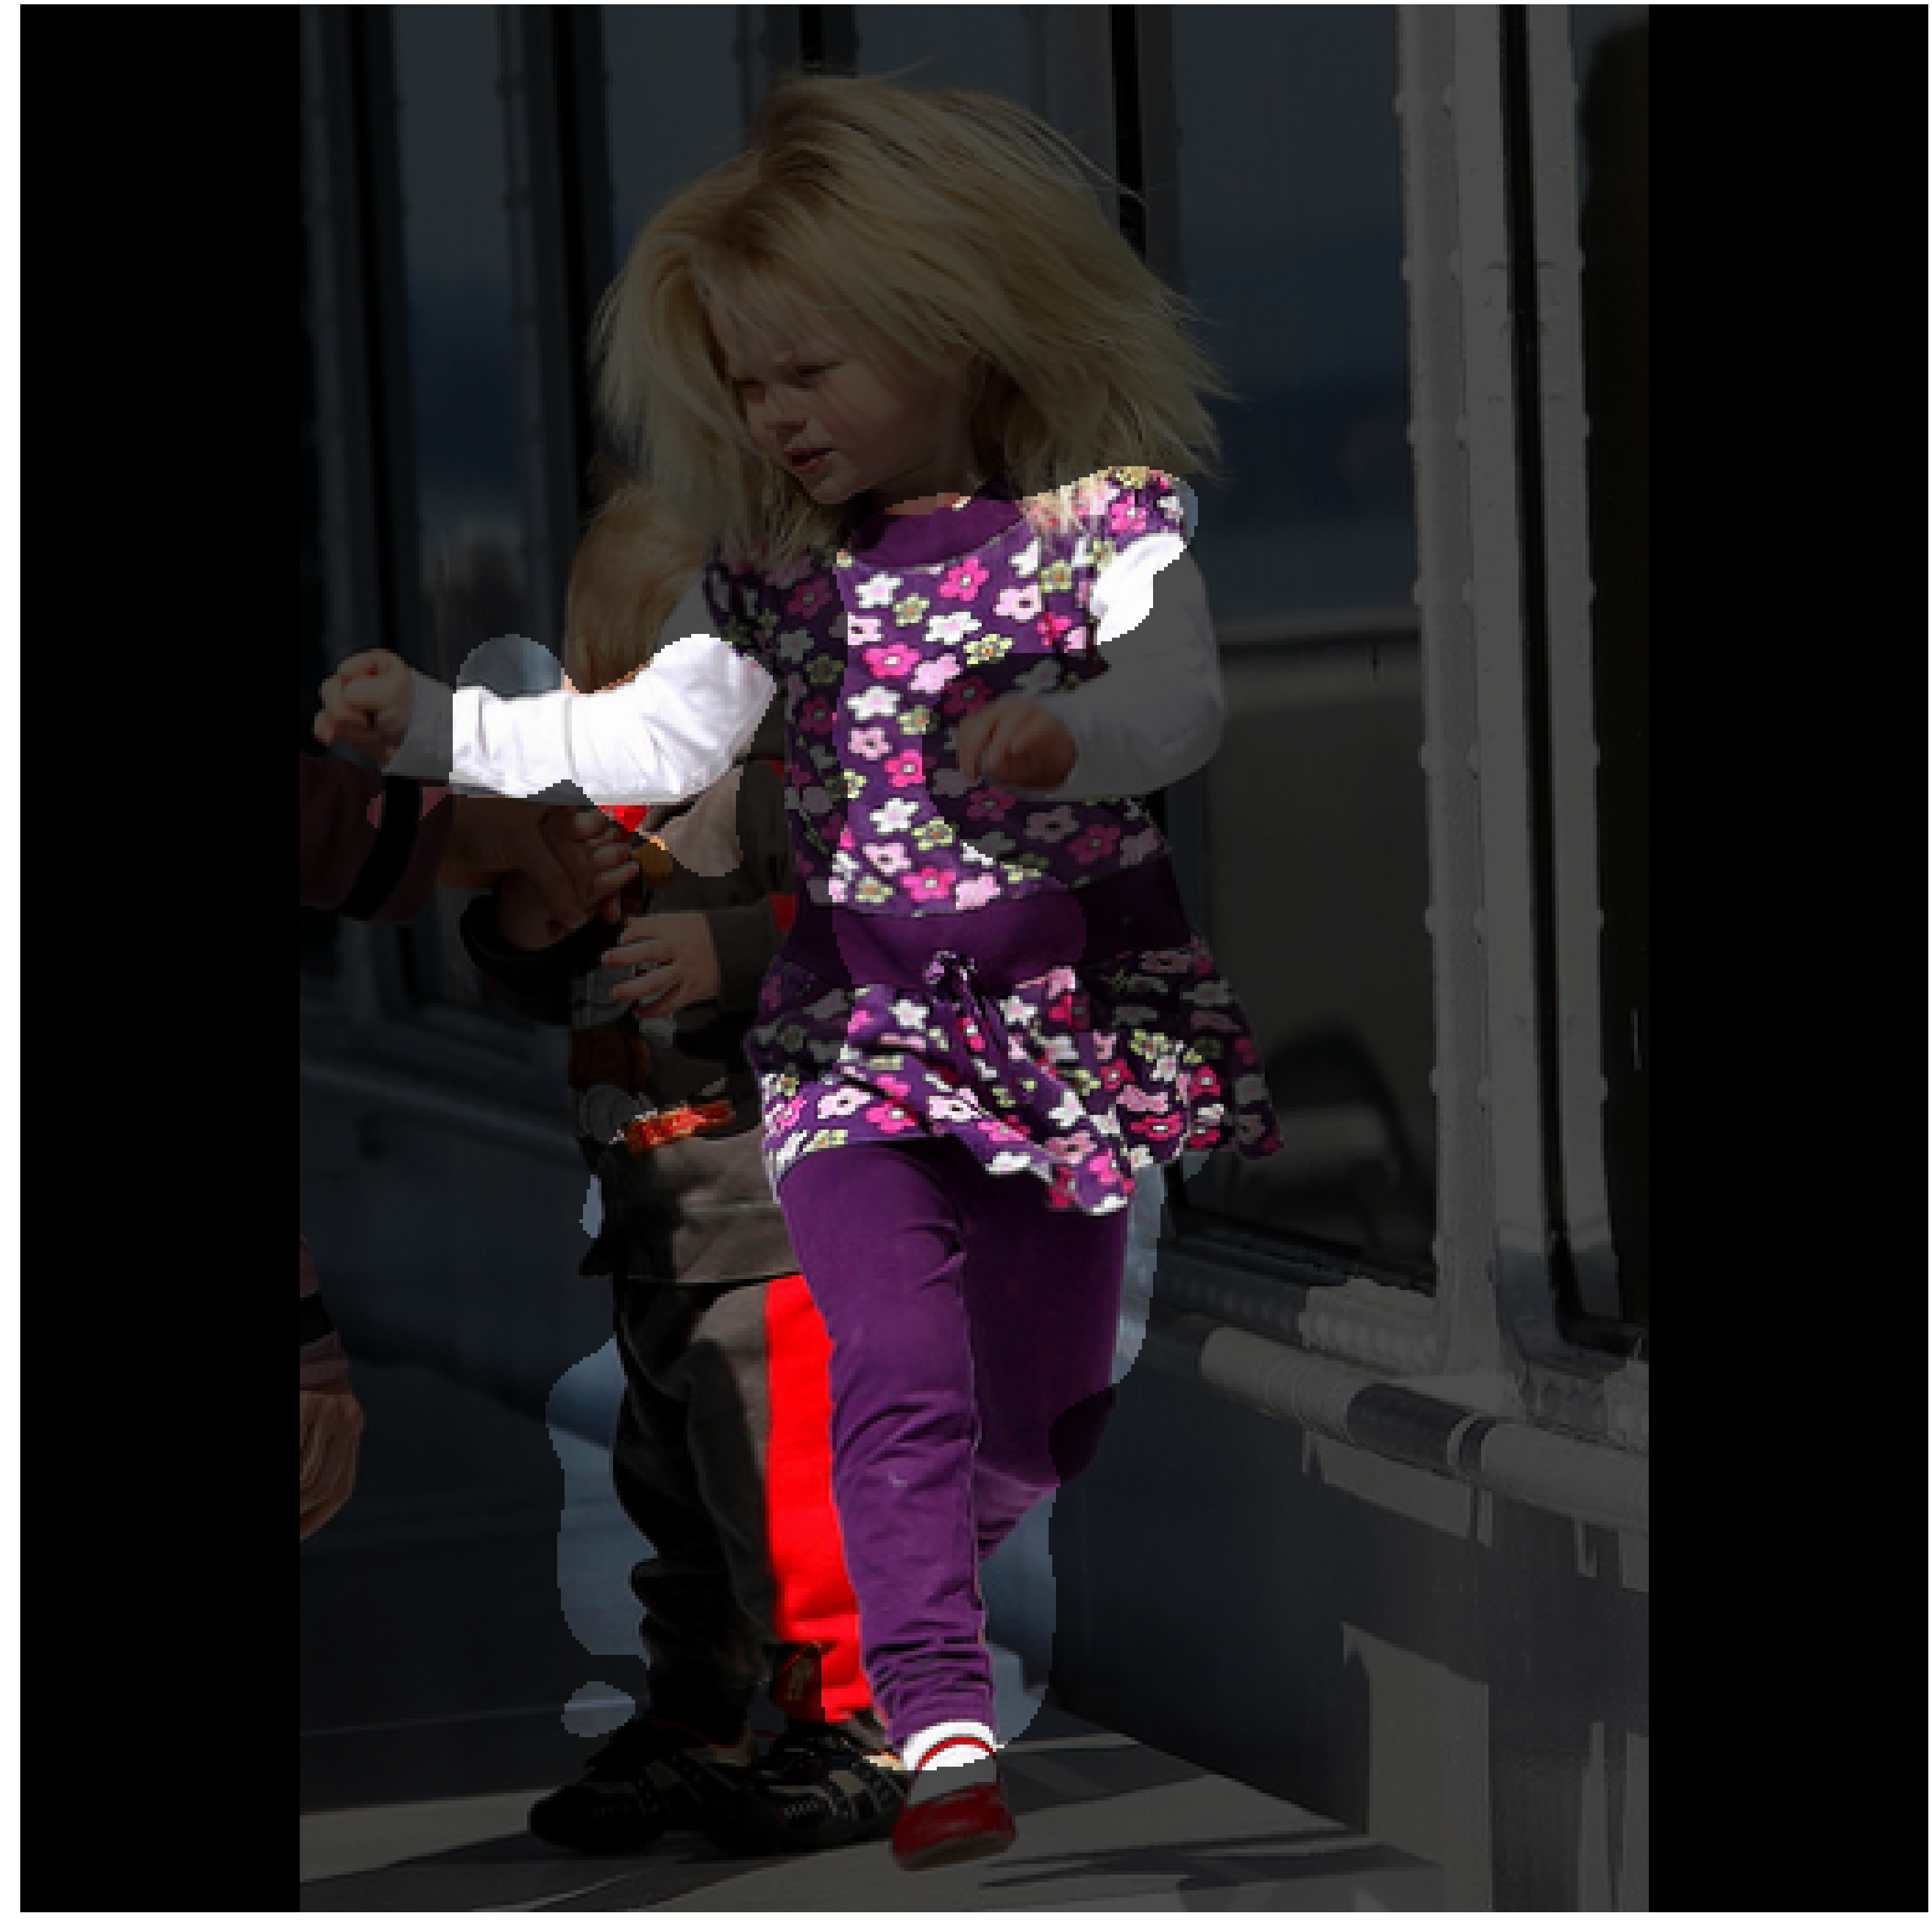

In [48]:
att_avg = np.mean(att, axis=0)
masks = np.zeros([1, input_image.shape[0], input_image.shape[1], 3])
for i in range(1):
    s = 32
    att1 = np.reshape(att_avg, (s, s))
    att1 = zoom(att1, float(input_image.shape[0]) / att1.shape[-1], order=1)
    att1 = (att1 - (np.min(att1))) / (np.max(att1) - np.min(att1))
    att1 = gaussian_filter(att1, sigma=sig)
    
    plt.imshow(att1)
    att1[att1 > th] = 1
    att1[att1 <= th] = 0.3
    mask = att1

    for c in range(3):
        masks[i,:, :, c] = input_image[:, :, c] * mask
        
display_images_c(masks, sz=input_image.shape[0]/2)

### Compute mAP @ IoU=0.5 on Batch of Images

  0%|          | 0/2000 [00:00<?, ?it/s]

2000


100%|██████████| 2000/2000 [22:15<00:00,  1.50it/s]


precisions  [[0.47967886 0.47967886 0.49293701 0.5036657  0.52022396 0.53936077
  0.55370773 0.58232181 0.61962043 0.67589286 0.7505002 ]
 [0.45469876 0.45469876 0.46722369 0.47659769 0.49355175 0.50979037
  0.52308767 0.55098723 0.58988613 0.64308036 0.71548619]
 [0.42211353 0.42211353 0.43287911 0.44202762 0.45773232 0.47204775
  0.48795461 0.51539489 0.5511784  0.60394345 0.67707083]
 [0.38741929 0.38741929 0.39799293 0.40511975 0.41981988 0.43316857
  0.44621705 0.47289715 0.50806246 0.56421131 0.6372549 ]
 [0.34752416 0.34752416 0.35735698 0.36262499 0.37637504 0.38861284
  0.40159893 0.42588833 0.45268806 0.50558036 0.57002801]
 [0.28925933 0.28925933 0.29754452 0.30193289 0.31276932 0.32191253
  0.33235734 0.35130127 0.37611111 0.42355655 0.47515006]
 [0.22409198 0.22409198 0.22993222 0.23203734 0.23870299 0.24601708
  0.25483165 0.26839327 0.29481884 0.33022321 0.38347339]
 [0.15169381 0.15169381 0.15405373 0.15448783 0.15832085 0.1634815
  0.16961585 0.1774397  0.19551932 0.22

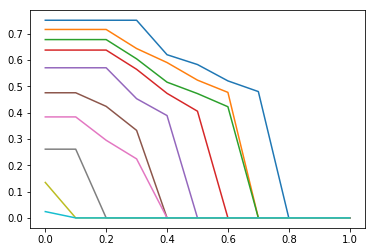

In [49]:
from tqdm import tqdm
if True:
    conf_hist = np.zeros([10, 1])
    
    def compute_batch_ap(image_ids):
        APs = []
        no_count = np.zeros([10, 11])
        cRCs = []
        cPrs = []
        conf1 = np.zeros([1,1])
         
        for image_id in tqdm(image_ids):
            # Load image
            image, image_meta, gt_class_id, gt_bbox, en_caption, bbox, captions, en_captions  = \
                    modellib.load_image_gt(dataset, config,
                                           image_id, use_mini_mask=False)
            gt_class_id[gt_class_id > 0] = 1
            prev_caps = np.zeros((config.BATCH_SIZE, config.SEQ_LEN), dtype=int)
            prev_caps[0, :len(en_caption)] = en_caption
                
            target_caps = np.zeros((1, config.SEQ_LEN), dtype=int)
            target_caps[0, :-1] = prev_caps[0, 1:]
            sample_weight = np.zeros((1, config.SEQ_LEN), dtype=int)
            sample_weight[target_caps > 0] = 1

            pred_match = np.array([])
            RCs = np.zeros([10, 11])
            Prs = np.zeros([10, 11])
            conf1 = np.zeros([1,1])
            conf1[0,0] = 0.45
            
            for i in range(11):
                # Run object detection
                results = model.detect(prev_caps, sample_weight, conf1, [image], verbose=0)
                r = results[0]
                conf1[0,0] += 0.05
                
                iou_th = 0.5
                
                for j in range(10):
                    AP, precisions, recalls, overlaps, pred_match, gt_match = \
                            utils.compute_ap(gt_bbox, gt_class_id,
                                             r['rois'], r['class_ids'], r['scores'], iou_threshold=iou_th)
                    iou_th += 0.05
                    
                    if pred_match.size == 0:
                        no_count[j, i] += 1
                        Prs[j, i] = -1
                        RCs[j, i] = 0
                    else:
                        Prs[j, i] = np.mean(pred_match)
                        RCs[j, i] = np.mean(gt_match)

            cRCs.append(RCs)
            cPrs.append(Prs)
        
        cRCs = np.array(cRCs)
        cPrs = np.array(cPrs)
        return cRCs, cPrs, no_count


    # Pick a set of random images
    print(len(dataset.image_ids1))
    image_ids = np.random.choice(dataset.image_ids1, 2000)
    cRCs, cPrs, no_count = compute_batch_ap(image_ids)
    
    tpr = np.sum(cPrs!=-1, axis=0)
    cPrs[cPrs==-1] = 0
    precisions = np.sum(cPrs, axis=0)/tpr
    recalls = np.mean(cRCs, axis=0)
    
    print("precisions ", precisions)
    print("recalls ", recalls)
    print("no_count ", no_count)
    
    gr = np.zeros([10, 11])
    gp = np.zeros([10, 11])
    
    for i in range(10):
        rr = 0.0
        for j in range(11):
            gr[i, j] = rr
            tp = precisions[i, recalls[i, :] >= rr]
            if tp.size != 0:
                gp[i, j] = np.amax(tp)
            else:
                gp[i, j] = 0
            rr += 0.1
        
        print("mAP: ", np.mean(gp[i, :]))
    
    plt.figure()
    for i in range(10):
        plt.plot(gr[i, :], gp[i, :])

### Compute Recall @1, 5, 10

In [50]:
from tqdm import tqdm
if True:
    conf_hist = np.zeros([10, 1])
    def compute_recall(image_ids):
        APs = []
        no_count = 0
        cRCs = []
        cPrs = []
        conf1 = np.zeros([1,1])
         
        for image_id in tqdm(image_ids):
            # Load image
            image, image_meta, gt_class_id, gt_bbox, en_caption, bbox, captions, en_captions  = \
                    modellib.load_image_gt(dataset, config,
                                           image_id, use_mini_mask=False)
            gt_class_id[gt_class_id > 0] = 1
            prev_caps = np.zeros((config.BATCH_SIZE, config.SEQ_LEN), dtype=int)
            prev_caps[0, :len(en_caption)] = en_caption
                
            target_caps = np.zeros((1, config.SEQ_LEN), dtype=int)
            target_caps[0, :-1] = prev_caps[0, 1:]
            sample_weight = np.zeros((1, config.SEQ_LEN), dtype=int)
            sample_weight[target_caps > 0] = 1

            pred_match = np.array([])
            RCs = np.zeros([3])
            Prs = 0
            conf1 = np.zeros([1,1])
            conf1[0,0] = 0.45
            
            # Run object detection
            results = model.detect(prev_caps, sample_weight, conf1, [image], verbose=0)
            r = results[0]
            conf1[0,0] += 0.05

            iou_th = 0.5

            AP, precisions, recalls, overlaps, pred_match, gt_match = \
                    utils.compute_ap(gt_bbox, gt_class_id,
                                     r['rois'], r['class_ids'], r['scores'], iou_threshold=iou_th)

            if pred_match.size == 0:
                continue
            else:
                select_index = np.where(r['class_ids'] == 1)
                r['scores'] = r['scores'][select_index]
                pred_match = pred_match[select_index]
                list1, list2 = zip(*sorted(zip(r['scores'], pred_match), reverse=True))
                if list2[0] == 1:
                    RCs[0] = 1
                else:
                    RCs[0] = 0
                if np.sum(list2[:5]) > 0:
                    RCs[1] = 1
                else:
                    RCs[1] = 0
                if np.sum(list2[:10]) > 0:
                    RCs[2] = 1
                else:
                    RCs[2] = 0
                    
            cRCs.append(RCs)

        cRCs = np.array(cRCs)
        return cRCs


    # Pick a set of random images
    print(len(dataset.image_ids1))
    image_ids = np.random.choice(dataset.image_ids1, 2000)
    cRCs = compute_recall(image_ids)
    recalls = np.mean(cRCs, axis=0)
    print("recalls ", recalls)

  0%|          | 2/2000 [00:00<02:35, 12.84it/s]

2000


100%|██████████| 2000/2000 [02:34<00:00, 12.98it/s]

recalls  [0.56582915 0.77889447 0.7879397 ]


### Compute RPN Recall

In [51]:
from tqdm import tqdm
if True:
    conf_hist = np.zeros([10, 1])
    def compute_batch_ap(image_ids):
        APs = []
        no_count = 0
        cRCs = []
        cPrs = []
        conf1 = np.zeros([1,1])
         
        iou_threshold = 0.5
        for image_id in tqdm(image_ids):
            # Load image
            image, image_meta, gt_class_id, gt_bbox, en_caption, bbox, captions, en_captions  = \
                    modellib.load_image_gt(dataset, config,
                                           image_id, use_mini_mask=False)
            
            prev_caps = np.zeros((config.BATCH_SIZE, config.SEQ_LEN), dtype=int)
            prev_caps[0, :len(en_caption)] = en_caption
            sample_weight = np.zeros((1, config.SEQ_LEN), dtype=int)
            sample_weight[target_caps > 0] = 1
            
            # Run RPN sub-graph
            pillar = model.keras_model.get_layer("ROI").output  # node to start searching from

            # TF 1.4 and 1.9 introduce new versions of NMS. Search for all names to support TF 1.3~1.10
            nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression:0")
            if nms_node is None:
                nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV2:0")
            if nms_node is None: #TF 1.9-1.10
                nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV3:0")

            rpn = model.run_graph(prev_caps, sample_weight, conf, [image], [
                ("proposals", model.keras_model.get_layer("ROI").output)
            ])

            limit = 1000000
            h, w = config.IMAGE_SHAPE[:2]
            proposals = rpn['proposals'][0, :limit] * np.array([h, w, h, w])
            
            RCs, positive_anchor_ids = utils.compute_recall(proposals, gt_bbox, iou_threshold)
            cRCs.append(RCs)
        
        cRCs = np.array(cRCs)
        return cRCs, no_count


    # Pick a set of random images
    print(len(dataset.image_ids1))
    image_ids = np.random.choice(dataset.image_ids1, 2000)
    cRCs, no_count = compute_batch_ap(image_ids)
    
    recalls = np.mean(cRCs)
    print("recalls ", recalls)
    print("no_count ", no_count)

  0%|          | 0/2000 [00:00<?, ?it/s]

2000


100%|██████████| 2000/2000 [41:11<00:00,  1.24s/it]

recalls  0.8934356542150661
no_count  0
